# Laboratorium 4 - segmentacje

## Przygotowanie

 * pobierz i wypakuj dataset: https://data.world/socialmediadata/beeradvocate
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab4`
 * zainstaluj potrzebne biblioteki:
 `pip install gensim==3.8.3 wordcloud==1.8.1`

## Część 1. - przygotowanie danych

In [1]:
# importujemy potrzebne pakiety

from collections import Counter, defaultdict
import codecs
import csv

from gensim.corpora import Dictionary
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from wordcloud import WordCloud

In [2]:
PATH = 'socialmediadata-beeradvocate/data/beer_reviews.csv'
SCORE_THRESHOLD = 4 # recenzje z co najmniej taka ocena wezmiemy pod uwage
VECTOR_SIZE = 20 # jak dlugie powinny byc wektory osadzen uzytkownikow
SEGMENTS_COUNT = 10 # na ile segmentow chcemy podzielic populacje uzytkownikow

In [3]:
# wczytujemy dane

def parse_headers(column_names):
    beer_id_column =  column_names.index('beer_beerid')
    beer_style_column = column_names.index('beer_style')
    user_id_column =  column_names.index('review_profilename')
    score_column =  column_names.index('review_overall')
    return beer_id_column, beer_style_column, user_id_column, score_column


def parse_review(line, beer_id_column, beer_style_column, user_id_column, score_column):
    return line[beer_id_column], line[beer_style_column], line[user_id_column], float(line[score_column])

def read_and_parse_reviews(path, score_threshold):
    with codecs.open(PATH, 'r', 'UTF-8') as datafile:
        datareader = csv.reader(datafile)
        beer_id_column, beer_style_column, user_id_column, score_column = parse_headers(next(datareader))
    
        users_favourite_beers = defaultdict(list)
        for review in datareader:
            beer_id, _, user_id, score = parse_review(review, beer_id_column, beer_style_column, user_id_column, score_column)
            if score >= score_threshold:
                users_favourite_beers[user_id].append(beer_id)

    return users_favourite_beers

def get_beer_id_to_style_mapping(path):
    with codecs.open(PATH, 'r', 'UTF-8') as datafile:
        datareader = csv.reader(datafile)
        beer_id_column, beer_style_column, user_id_column, score_column = parse_headers(next(datareader))
        beer_styles = {}
        for review in datareader:
            beer_id, beer_style, _, _ = parse_review(review, beer_id_column, beer_style_column, user_id_column, score_column)
            beer_styles[beer_id] = beer_style
        return beer_styles

# otrzymujemy slownik - mapowanie z user_id na liste ulubionych beer_ids
users_favourite_beers = read_and_parse_reviews(PATH, SCORE_THRESHOLD)

# dodatkowo przygotujmy sobie slownik mapujacy id piwa na nazwe stylu
beer_styles = get_beer_id_to_style_mapping(PATH)

## Część 2. - osadzenia użytkowników

In [5]:
# trenujemy model osadzajacy piwa i uzytkownikow w przestrzeni

model = Word2Vec(sentences=users_favourite_beers.values(), vector_size=VECTOR_SIZE, window=5, min_count=1, workers=4)

In [10]:
# na podstawie modelu obliczamy wektorowa reprezentacje uzytkownikow

def get_mean_vector_for_user(user_favourite_beers, model, vector_size):
    # inicjalizujemy wektor zerami
    v = np.zeros(vector_size)
    
    # iterujemy po liscie user_favourite_beers, odczytujemy z modelu wektor reprezentujacy kazde piwo i dodajemy do wektora
    #   uzyj: model.wv[beer_id]
    # ...
    for beer in user_favourite_beers:
        v += model.wv[beer]
    
    # normalizujemy wektor - dzielimy kazda wspolrzedna przez liczbe piw
    # ...
    v = v/len(user_favourite_beers)
    
    return v
    


def get_mean_user_vectors(users_favourite_beers, model, vector_size):
    # korzystajac z powyzszej funkcji, tworzymy slownik {user_id -> vector}
    # ...
    mean_users_vectors = {key:get_mean_vector_for_user(value, model, vector_size) for key, value in users_favourite_beers.items()}
    
    return mean_users_vectors

user_vectors = get_mean_user_vectors(users_favourite_beers, model, VECTOR_SIZE)

{'johnmichaelsen': array([ 0.55736678,  0.28876057, -0.25127408,  0.33578699, -0.2185554 ,
        -0.62237168, -0.55866952,  1.26709582, -0.17871535,  0.66685959,
         0.22601737, -0.38636232,  0.13745967,  0.51919795,  0.64456608,
         0.66796719,  0.29943712, -1.19464936, -0.52982996, -1.00912636]),
 'LordAdmNelson': array([ 1.02623604,  0.31963699, -0.6055754 ,  0.59366299, -0.45666264,
        -0.88618916, -0.74759021,  1.79552458,  0.2239857 ,  1.13976484,
        -0.42474938, -0.67838143,  0.62616567,  0.89466947,  1.25022571,
         1.09941221,  0.4112522 , -1.92274359, -0.88810271, -2.13868742]),
 'augustgarage': array([ 0.83480271,  0.43092986, -0.26026317,  0.51156909, -0.24271983,
        -0.76991668, -0.73914242,  1.47261033, -0.06484275,  0.833158  ,
         0.45143969, -0.47686874,  0.28289563,  0.63053146,  0.76986062,
         0.90495525,  0.28362597, -1.46124553, -0.69483478, -1.40245804]),
 'MadeInOregon': array([ 0.69876939,  0.11469589, -0.77156966,  1.0

## Część 3. - klasteryzacja

In [20]:
# klastrujemy uzytkownikow - mozemy uzyc wielu algorytmow, np k-means, agglomerative, BIRCH, ...

def get_users_segmentation(user_vectors, vector_size, segments_count, clustering_algorithm):
    # rozkladamy slownik user_vectors na liste uzytkownikow i liste wektorow
    #  - wazne jest zachowanie tej samej kolejnosci w obu listach
    users = list(user_vectors.keys())
    vectors = list(user_vectors.values())
    
    # zamieniamy liste wektorow w macierz
    users_array = np.stack(vectors, axis=0)
    # zaimplementuj wsparcie dla co najmniej jednego algorytmu wiecej
    if clustering_algorithm == 'agglomerative':
        clustering = AgglomerativeClustering(n_clusters=segments_count).fit_predict(users_array)
        # clustering to lista przypisanych klastrow - i-ty element to klaster, do ktorego nalezy i-ty wektor
    
    # jesli nie pomieszalismy kolejnosci w listach, to mozemy odzyskac mapping user_id -> cluster
    # ...
    segmentation = {key:value for (key, value) in zip(users, clustering)}
    
    return segmentation


segmentation = get_users_segmentation(user_vectors, VECTOR_SIZE, SEGMENTS_COUNT, 'agglomerative')

segmentation

{'johnmichaelsen': 3,
 'LordAdmNelson': 3,
 'augustgarage': 3,
 'MadeInOregon': 3,
 'rawthar': 3,
 'Halcyondays': 3,
 'beerguy101': 3,
 'UCLABrewN84': 3,
 'zaphodchak': 3,
 'Tilley4': 3,
 'mikedrinksbeer2': 3,
 'dbmernin83': 3,
 'titosupertramp': 3,
 'optimator13': 3,
 'Blakaeris': 3,
 'bashiba': 3,
 'Klym': 3,
 'flexabull': 3,
 'Bung': 3,
 'oberon': 3,
 't420o': 3,
 'DarthKostrizer': 3,
 'MrVonzipper': 3,
 'TheWhiskerReview': 3,
 'Jason': 3,
 'DoubleJ': 3,
 'Deuane': 3,
 'Mattybeerguy': 5,
 'micromaniac129': 3,
 'northyorksammy': 3,
 'vette2006c5r': 3,
 'EvanEngelstad': 3,
 'djeucalyptus': 3,
 'ccrida': 3,
 'brewandbbq': 3,
 'hopsbreath': 3,
 'Slatetank': 3,
 'Proteus93': 3,
 'SShelly': 3,
 'zoso1967': 3,
 'msubulldog25': 3,
 'NJpadreFan': 3,
 'd0ggnate': 3,
 'Cyberkedi': 3,
 'babyhobbes': 3,
 'mdagnew': 3,
 'mikesgroove': 3,
 'hdofu': 3,
 'GratefulBeerGuy': 3,
 'PDXHops': 3,
 'IMincedTheKing': 3,
 'Goliath': 3,
 'zeff80': 3,
 'akorsak': 3,
 'wchesak': 3,
 'bfields4': 3,
 'dyan': 3,
 

In [22]:
# obliczamy licznosci segmentow

def get_segment_sizes(segmentation):
    # ...
    segment_sizes = np.zeros(SEGMENTS_COUNT)
    for _, segment in segmentation.items():
        segment_sizes[segment] += 1
    
    return segment_sizes
    

get_segment_sizes(segmentation)

array([ 1447.,  2171.,  2382., 15692.,  1093.,  4294.,  1210.,   784.,
         539.,   674.])

## Część 4. - opisy segmentów

In [31]:
# obliczamy popularnosc styli w segmentach oraz w calej populacji
#  - czyli jak czesto kazdy ze styli wystepowal

def get_per_segment_styles_popularity(users_favourite_beers, beer_styles, segmentation, segments_count):
    beer_styles_per_segment = {i: defaultdict(lambda: 0) for i in range(segments_count)}
    # do tego slownika bedziemy sie odwolywac np. tak: beer_styles_per_segment[segment][style]
    
    for user, beers in users_favourite_beers.items():
        for beer in beers:
            beer_styles_per_segment[segmentation[user]][beer_styles[beer]] += 1
    
    return beer_styles_per_segment

def get_total_styles_popularity(beer_styles_per_segment):
    total_popularity = defaultdict(lambda: 0)
    # ...
    for _, styles in beer_styles_per_segment.items():
        for style, count in styles.items():
            total_popularity[style] += count
    return total_popularity

per_segment_styles_popularity = get_per_segment_styles_popularity(users_favourite_beers, beer_styles, segmentation, SEGMENTS_COUNT)
total_styles_popularity = get_total_styles_popularity(per_segment_styles_popularity)

total_styles_popularity


defaultdict(<function __main__.get_total_styles_popularity.<locals>.<lambda>()>,
            {'American Amber / Red Ale': 27301,
             'American IPA': 84529,
             'American Strong Ale': 21493,
             'American Double / Imperial IPA': 63326,
             'American Black Ale': 8254,
             'Schwarzbier': 6267,
             'Russian Imperial Stout': 41038,
             'Czech Pilsener': 7619,
             'American Pale Ale (APA)': 40693,
             'Belgian Strong Pale Ale': 21242,
             'American Brown Ale': 16484,
             'American Porter': 34604,
             'Hefeweizen': 18951,
             'Lambic - Fruit': 7300,
             'English India Pale Ale (IPA)': 9095,
             'Fruit / Vegetable Beer': 13821,
             'English Dark Mild Ale': 1439,
             'American Double / Imperial Stout': 38460,
             'Belgian Strong Dark Ale': 26088,
             'American Stout': 16177,
             'Scottish Ale': 5436,
             'Sai

In [42]:
# przygotujmy dwa opisy segmentow - top N najpopularniejszych stylow w kazdym segmencie
#   oraz top N unikalnych - to samo, ale popularnosc w segmencie dzielimy przez laczna popularnosc
#   dla potrzeb wizualizacji w nastepnym kroku, zwroc slownik {segment_id -> {style_id -> frequency}}

def most_popular_styles_per_segment(per_segment_styles_popularity, N):
    # ...
    most_popular = {i: defaultdict(lambda: 0) for i in range(SEGMENTS_COUNT)}
    for segment, styles in per_segment_styles_popularity.items():
        most_popular[segment] = dict(sorted(styles.items(), key=lambda i: i[1], reverse=True)[:N])
        
    return most_popular

def most_distinctive_styles_per_segment(total_styles_popularity, per_segment_styles_popularity, N):
    # ...
    most_distinctive = {i: defaultdict(lambda: 0) for i in range(SEGMENTS_COUNT)}
    for segment, styles in per_segment_styles_popularity.items():
        styles = {key:value/total_styles_popularity[key] for key, value in styles.items()}
        most_distinctive[segment] = dict(sorted(styles.items(), key=lambda i: i[1])[:N])
        
    return most_distinctive
     
top_N = 50
most_popular = most_popular_styles_per_segment(per_segment_styles_popularity, top_N)
most_distinctive = most_distinctive_styles_per_segment(total_styles_popularity, per_segment_styles_popularity, top_N)

most_distinctive

{0: {'Euro Pale Lager': 0.0002042483660130719,
  'American Double / Imperial Pilsner': 0.0002836074872376631,
  'Maibock / Helles Bock': 0.00030079711234772146,
  'Dortmunder / Export Lager': 0.00036075036075036075,
  'Extra Special / Strong Bitter (ESB)': 0.0003674106732800588,
  'California Common / Steam Beer': 0.00038684719535783365,
  'Berliner Weissbier': 0.00043271311120726956,
  'Wheatwine': 0.0004347826086956522,
  'Herbed / Spiced Beer': 0.0004574565416285453,
  'American Barleywine': 0.0004922067268252667,
  'Old Ale': 0.0004992012779552715,
  'Belgian Dark Ale': 0.0005314908317831517,
  'Smoked Beer': 0.0005497526113249038,
  'Fruit / Vegetable Beer': 0.0006511829824180595,
  'Witbier': 0.0006758659532526049,
  'American Amber / Red Lager': 0.0007122507122507123,
  'Foreign / Export Stout': 0.0007398273736128237,
  'Oatmeal Stout': 0.0007765783955890347,
  'English Barleywine': 0.0008015573113477613,
  'Rauchbier': 0.0008143322475570033,
  'Bock': 0.0008433125316242199,
  '

## Część 5. - wizualizacja

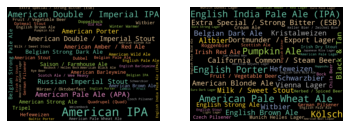

In [43]:
# teraz mozemy zwizualizowac nasze segmentacje za pomoca word clouds
#   zauwaz, jak roznia sie obie metody opisow segmentow oraz opisy miedzy poszczegolnymi segmentami

def visualise_styles(most_popular, most_distinctive, segment_id):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    wordcloud1 = WordCloud(width = 1000, height = 750, random_state=42, background_color='black', colormap='Set2', collocations=False)
    wordcloud1.generate_from_frequencies(frequencies=most_popular[segment_id])
    ax1.imshow(wordcloud1, interpolation="bilinear")
    wordcloud2 = WordCloud(width = 1000, height = 750, random_state=42, background_color='black', colormap='Set2', collocations=False)
    wordcloud2.generate_from_frequencies(frequencies=most_distinctive[segment_id])
    ax2.imshow(wordcloud2, interpolation="bilinear")
    ax1.axis("off")
    ax2.axis("off")
    plt.show()
    
visualise_styles(most_popular, most_distinctive, 3)